해당 노트북은 고려대학교 정보대학 딥러닝 학회 [AIKU](https://github.com/AIKU-Official) D2D 과제 내용을 바탕으로 작성되었습니다.

# 환경설정

In [1]:
from google.colab import drive
drive.mount('/content/drive')
FOLDERNAME = '/AIKU/Github/AIKU-DL-Paper-Review/code_practices/PyTorch'
assert FOLDERNAME is not None, "[!] Enter the foldername."
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME/datasets/
!bash get_datasets.sh
%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/AIKU/Github/AIKU-DL-Paper-Review/code_practices/PyTorch/datasets
/content/drive/My Drive/AIKU/Github/AIKU-DL-Paper-Review/code_practices/PyTorch


In [2]:
# GPU
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler

import torchvision.datasets as dset
import torchvision.transforms as T

import numpy as np
import matplotlib.pyplot as plt

USE_GPU=True
dtype=torch.float32

if USE_GPU and torch.cuda.is_available():
    device=torch.device('cuda')
else:
    device=torch.device('cpu')

print('using device: ',device)

using device:  cuda


# 목차

+ **Part1**.   준비
+ **Part2**.   Barebones PyTorch : 추상화 수준 1
+ **Part3**.   PyTorch Module API : 추상화 수준 2/ `nn.Module` 사용
+ **Part4**.   PyTorch Sequential API :추상화 수준 3/ `nn.Sequential` 사용
+ **Part5**.   CIFAR-10 open-ended challenge
+ **Part6**.   Pretrained model

<br>
  
참고: PyTorch 추상화 수준별 비교
    
| API | 유연성 | 편의성 |
|---------------|-------------|-------------|
| Barebones | 높음 | 낮음 |
| `nn.Module` | 높음 | 중간 |
| `nn.Sequential` | 낮음 | 높음 |


# **Part1. 준비**

 The `torchvision.transforms` package provides tools for **preprocessing data and for performing data augmentation**;  
 here we set up a transform to preprocess the data *by subtracting the mean RGB value and dividing by the standard deviation of each RGB value*;    
 we've hardcoded the mean and std.

## Preprocessing

In [3]:
# Preprocessing
transform=T.Compose([
    T.ToTensor(),
    T.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
])

We set up a Dataset object for each split (train / val / test);  
Datasets load training examples one at a time, so we wrap each Dataset in a `DataLoader` which iterates through the Dataset and forms minibatches.  
We divide the CIFAR-10 training set into train and val sets by passing a `Sampler` object to the DataLoader telling how it should sample from the underlying Dataset.

## DataLoader

In [4]:
# DataLoader
NUM_TRAIN=49000

cifar_10_train=dset.CIFAR10('./datasets',train=True,download=True,transform=transform)
loader_train=DataLoader(cifar_10_train,batch_size=64,
                        sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN))) #train 49,000장

cifar_10_val=dset.CIFAR10('./datasets',train=True,download=True,transform=transform)
loader_val=DataLoader(cifar_10_train,batch_size=64,
                      sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN,50000))) #val1,000장

cifar_10_test=dset.CIFAR10('./datasets',train=False,download=True,transform=transform)
loader_test=DataLoader(cifar_10_test,batch_size=64)

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


## Original Images

In [5]:
def org_imshow(transformed_tensor):
    means=np.array([0.4914, 0.4822, 0.4465])
    stds=np.array([0.2023, 0.1994, 0.2010])
    tmp=[]
    for i in range(3):
        tmp.append(np.array((transformed_tensor[i]))*stds[i]+means[i])
    plt.imshow(np.transpose(tmp,(1,2,0)))

첫번째 배치 shape: torch.Size([64, 3, 32, 32])
첫번째 배치 class: torch.Size([64])


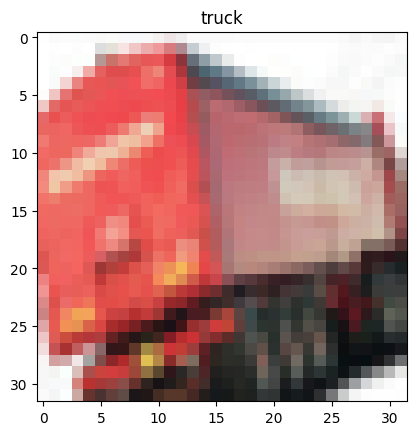

In [6]:
for batch in loader_train:
    print('첫번째 배치 shape:',batch[0].shape)
    print('첫번째 배치 class:',batch[1].shape)
    org_imshow(batch[0][0])
    plt.title(cifar_10_train.classes[batch[1][0]])
    break

# **Part2. Barebones PyTorch**

## PyTorch Tensors: Flatten 함수

In [7]:
def flatten(x):
    N=x.shape[0] # read in N,C,H,W
    return x.view(N,-1) # "flatten" the C * H * W values into a single vector per image

In [8]:
def test_flatten():
    x=torch.arange(12).view(2,1,3,2)
    print('**Before flattening** \n',x)
    print(x.shape)
    print('='*30+'>>')
    print('**After flattening** \n',flatten(x))
    print(flatten(x).shape)

In [9]:
test_flatten()

**Before flattening** 
 tensor([[[[ 0,  1],
          [ 2,  3],
          [ 4,  5]]],


        [[[ 6,  7],
          [ 8,  9],
          [10, 11]]]])
torch.Size([2, 1, 3, 2])
==============================>>
**After flattening** 
 tensor([[ 0,  1,  2,  3,  4,  5],
        [ 6,  7,  8,  9, 10, 11]])
torch.Size([2, 6])


## 2-1.Barebones PyTorch: Two-Layer Network
여기에서는 이미지 데이터 배치에 대해 완전히 연결된 2계층 ReLU 네트워크의 포워드 패스를 수행하는 함수 `two_layer_fc`를 정의합니다.  
포워드 패스를 정의한 후에는 네트워크를 통해 0을 실행하여 충돌이 발생하지 않는지, 올바른 모양의 출력을 생성하는지 확인합니다.  
여기서 코드를 작성할 필요는 없지만 구현을 읽고 이해하는 것이 중요합니다.

In [10]:
import torch.nn.functional as F # useful stateless functions

def two_layer_fc(x,params):
    """
    A fully-connected neural networks; the architecture is:
    NN is fully connected -> ReLU -> fully connected layer.
    Note that this function only defines the forward pass;
    PyTorch will take care of the backward pass for us.

    The input to the network will be a minibatch of data, of shape
    (N, d1, ..., dM) where d1 * ... * dM = D. The hidden layer will have H units,
    and the output layer will produce scores for C classes.

    Inputs:
    - x: A PyTorch Tensor of shape (N, d1, ..., dM) giving a minibatch of
      input data.
    - params: A list [w1, w2] of PyTorch Tensors giving weights for the network;
      w1 has shape (D, H) and w2 has shape (H, C).

    Returns:
    - scores: A PyTorch Tensor of shape (N, C) giving classification scores for
      the input data x.
    """

    # first we flatten the image
    x=flatten(x) # shape: [batch_size, C x H x W]->없어도 됨

    w1,w2=params

    # Forward pass: compute predicted y using operations on Tensors. Since w1 and
    # w2 have requires_grad=True, operations involving these Tensors will cause
    # PyTorch to build a computational graph, allowing automatic computation of
    # gradients. Since we are no longer implementing the backward pass by hand we
    # don't need to keep references to intermediate values.
    # you can also use `.clamp(min=0)`, equivalent to F.relu()
    x=F.relu(x.mm(w1)) #mm: matrix multiplication
    x=x.mm(w2)
    return x

In [11]:
def two_layer_fc_test():
    hidden_layer_size=42
    x=torch.zeros((64,50),dtype=dtype)
    w1=torch.zeros((50,hidden_layer_size),dtype=dtype)
    w2=torch.zeros((hidden_layer_size,10),dtype=dtype)
    scores=two_layer_fc(x,[w1,w2])
    print(scores.size())

two_layer_fc_test()

torch.Size([64, 10])


## 2-2.Barebones PyTorch: Three-Layer ConvNet

여기서는 3계층 Convolution 네트워크의 순방향 패스를 수행하는 `three_layer_convnet` 함수의 구현을 완료합니다. 위와 같이 네트워크에 0을 전달하여 구현을 즉시 테스트할 수 있습니다. 네트워크는 다음과 같은 구조를 가져야 합니다:

1. `channel_1` 필터가 있는 Convolution 레이어(bias 포함), 각각 모양이 `KW1 x KH1`이고 zero padding 이 2입니다.
2. ReLU nonlinearity
3. `channel_2` 필터가 있는 Convolution 레이어(bias 포함), 각 필터의 모양이 `KW2 x KH2`이고 제로 패딩이 1입니다.
4. ReLU nonlinearity
5. bias가 있는 Fully-connected layer, C 클래스에 대한 점수를 생성합니다.

Fully-connected layer 이후에는 **소프트맥스 활성화가 없음**에 유의하십시오: 이는 PyTorch의 교차 엔트로피 손실이 소프트맥스 활성화를 수행하기 때문이며, 이 단계를 번들로 묶으면 계산이 더 효율적이기 때문입니다.

In [12]:
def three_layer_convnet(x,params):
    """
    Performs the forward pass of a three-layer convolutional network with the
    architecture defined above.

    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?

    Returns:
    - scores: PyTorch Tensor of shape (N, C) giving classification scores for x
    """
    conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b = params
    scores = None

    x=F.conv2d(input=x,weight=conv_w1,bias=conv_b1,padding=2) #1
    x=F.relu(x) #2
    x=F.conv2d(input=x,weight=conv_w2,bias=conv_b2,padding=1) #3
    x=F.relu(x) #4
    x=flatten(x)
    scores=x.mm(fc_w)+fc_b #5

    return scores

In [13]:
def three_layer_convnet_test():
    x=torch.zeros((64,3,32,32),dtype=dtype)

    conv_w1=torch.zeros((6,3,5,5),dtype=dtype) # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b1=torch.zeros((6,)) # out_channel
    conv_w2 = torch.zeros((9, 6, 3, 3), dtype=dtype)  # [out_channel, in_channel, kernel_H, kernel_W]
    conv_b2 = torch.zeros((9,))  # out_channel

    fc_w = torch.zeros((9 * 32 * 32, 10))
    fc_b = torch.zeros(10)

    scores = three_layer_convnet(x, [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b])
    print(scores.size())  # you should see [64, 10]

three_layer_convnet_test()

torch.Size([64, 10])


## 2-3.Barebones PyTorch: Initialization
모델의 가중치 행렬을 초기화하는 몇 가지 유틸리티 메서드를 작성해 보겠습니다.

- `random_weight(shape)`는 Kaiming normalization 방법으로 가중치 텐서를 초기화합니다.
- `zero_weight(shape)`는 모든 0으로 가중치 텐서를 초기화합니다. 바이어스 매개변수를 인스턴스화할 때 유용합니다.

`random_weight` 함수는 Kaiming normal initialization 방법을 사용합니다:

+ He et al, *Delving Deep into Rectifiers: Surpassing Human-Level Performance on ImageNet Classification*, ICCV 2015, https://arxiv.org/abs/1502.01852

- [Kaiming He Normal Initialization](https://imlim0813.tistory.com/25)   
$X\sim N(0,\sqrt{\frac{2}{fan_{in}}}^2)$



In [14]:
# Kaiming He Normal Initialization
def random_weight(shape):
    """
    Create random Tensors for weights; setting requires_grad=True means that we
    want to compute gradients for these Tensors during the backward pass.
    We use Kaiming normalization: sqrt(2 / fan_in)
    """
    if len(shape)==2: # FC layer [in_nodes,out_nodes]
        fan_in=shape[0]
    else:
        fan_in=np.prod(shape[1:]) # Conv layer [out_channel,in_channel,kH, kW]
    # randn is standard normal distribution generator.
    w=torch.randn(shape,device=device,dtype=dtype)*np.sqrt(2./fan_in)
    w.requires_grad=True # we want to compute gradients for these Tensors
                         # during the backward pass
    return w

In [15]:
# Zero Initialization
def zero_weight(shape):
    return torch.zeros(shape,device=device,dtype=dtype,requires_grad=True)

In [16]:
random_weight((3,5))

tensor([[ 0.3193,  0.3754,  0.9556, -0.1176,  0.0471],
        [ 0.0363,  1.2045,  0.5990,  0.5376, -0.6129],
        [ 0.0191,  0.8945, -0.0735, -0.0183, -1.5319]], device='cuda:0',
       requires_grad=True)

In [17]:
zero_weight((3,5))

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]], device='cuda:0', requires_grad=True)

## 2-4.Barebones PyTorch: Check Accuracy
모델을 훈련할 때 다음 함수를 사용하여 훈련 또는 검증 세트에서 모델의 정확도를 확인합니다.

정확도를 확인할 때 기울기를 계산할 필요가 없으므로 점수를 계산할 때 PyTorch가 계산 그래프를 만들 필요가 없습니다.  
그래프가 생성되는 것을 방지하기 위해 `torch.no_grad()` context manager에서 계산 범위를 지정합니다.

In [18]:
from tqdm import tqdm
def check_accuracy_part2(loader,model_fn,params):
    """
    Check the accuracy of a classification model.

    Inputs:
    - loader: A DataLoader for the data split we want to check
    - model_fn: A function that performs the forward pass of the model,
      with the signature scores = model_fn(x, params)
    - params: List of PyTorch Tensors giving parameters of the model

    Returns: Nothing, but prints the accuracy of the model
    """
    split=None
    if loader.dataset.train:
        split='valid'
        if loader.sampler.indices[-1]+1==NUM_TRAIN:
            split='train'
    else:
        split='test'
    print('[%s set accuracy]: ' % split,end=' ')

    num_correct,num_samples=0,0
    with torch.no_grad():
        for x,y in tqdm(loader):
            x=x.to(device=device,dtype=dtype)
            y=y.to(device=device,dtype=torch.int64)
            scores=model_fn(x,params)
            _,preds=scores.max(1) # row에서 최댓값,인덱스
            num_correct+=(preds==y).sum()
            num_samples+=preds.size(0)
        acc=float(num_correct)/num_samples
        print(': %d / %d correct (%.2f%%)' % (num_correct,num_samples,100*acc))

## 2-5. BareBones PyTorch: Training Loop
이제 네트워크를 훈련하기 위한 basic training loop를 설정할 수 있습니다. momentum 없이 Stochastic gradient descent를 사용하여 모델을 훈련할 것입니다. 여기서는 `torch.functional.cross_entropy`를 사용하여 loss를 계산할 것입니다(http://pytorch.org/docs/stable/nn.html#cross-entropy).

training loop는 신경망 함수, 초기화된 매개변수 목록(예제에서는 `[w1, w2]`), 학습 속도를 입력으로 받습니다.

In [19]:
def train_part2(model_fn,params,learning_rate):
    """
    Train a model on CIFAR-10.

    Inputs:
    - model_fn: A Python function that performs the forward pass of the model.
      It should have the signature scores = model_fn(x, params) where x is a
      PyTorch Tensor of image data, params is a list of PyTorch Tensors giving
      model weights, and scores is a PyTorch Tensor of shape (N, C) giving
      scores for the elements in x.
    - params: List of PyTorch Tensors giving weights for the model
    - learning_rate: Python scalar giving the learning rate to use for SGD

    Returns: Nothing
    """
    for batch_idx,(x,y) in enumerate(loader_train):
        # Move the data to the proper device (GPU or CPU)
        x=x.to(device=device,dtype=dtype)
        y=y.to(device=device,dtype=torch.long)

        # Forward pass: compute scores and loss
        scores=model_fn(x,params)
        loss=F.cross_entropy(scores,y)

        # Backward pass:
        ## PyTorch figures out which Tensors in the computational
        ## graph has requires_grad=True and uses backpropagation to compute the
        ## gradient of the loss with respect to these Tensors, and stores the
        ## gradients in the .grad attribute of each Tensor.
        loss.backward()

        # Update parameters:
        ## We don't want to backpropagate through the
        ## parameter updates, so we scope the updates under a torch.no_grad()
        ## context manager to prevent a computational graph from being built.
        with torch.no_grad():
            for w in params:
                w-=learning_rate*w.grad
                w.grad.zero_()  # Manually zero the gradients

        if batch_idx%100==0:
            print('Iteration %d, loss = %.4f'%(batch_idx,loss.item()))
            check_accuracy_part2(loader_val,model_fn,params)
            check_accuracy_part2(loader_train,model_fn,params)
            print()

## 2-6. Barebones PyTorch: Train a Two-Layer Network

In [20]:
hidden_layer_size = 4000
learning_rate = 1e-2

w1 = random_weight((3 * 32 * 32, hidden_layer_size))
w2 = random_weight((hidden_layer_size, 10))

train_part2(two_layer_fc, [w1, w2], learning_rate)

Iteration 0, loss = 3.6859
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 27.25it/s]


: 137 / 1000 correct (13.70%)
[train set accuracy]:  

100%|██████████| 766/766 [00:14<00:00, 52.45it/s]


: 7426 / 49000 correct (15.16%)

Iteration 100, loss = 2.4177
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 60.04it/s]


: 321 / 1000 correct (32.10%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 58.17it/s]


: 16534 / 49000 correct (33.74%)

Iteration 200, loss = 2.3682
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 62.91it/s]


: 352 / 1000 correct (35.20%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 56.94it/s]


: 16764 / 49000 correct (34.21%)

Iteration 300, loss = 1.7300
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 46.39it/s]


: 415 / 1000 correct (41.50%)
[train set accuracy]:  

100%|██████████| 766/766 [00:15<00:00, 50.42it/s]


: 21787 / 49000 correct (44.46%)

Iteration 400, loss = 1.9711
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 25.36it/s]


: 418 / 1000 correct (41.80%)
[train set accuracy]:  

100%|██████████| 766/766 [00:15<00:00, 48.75it/s]


: 21417 / 49000 correct (43.71%)

Iteration 500, loss = 1.5810
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 63.23it/s]


: 427 / 1000 correct (42.70%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 56.74it/s]


: 22192 / 49000 correct (45.29%)

Iteration 600, loss = 1.7049
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 41.51it/s]


: 433 / 1000 correct (43.30%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 55.18it/s]


: 23130 / 49000 correct (47.20%)

Iteration 700, loss = 1.8875
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 64.62it/s]


: 445 / 1000 correct (44.50%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 57.57it/s]


: 24123 / 49000 correct (49.23%)



## 2-7. BareBones PyTorch: Training a ConvNet
아래에서는 위에서 정의한 함수를 사용하여 CIFAR에서 3계층 Convolutional network를 훈련해야 합니다. 네트워크의 아키텍처는 다음과 같아야 합니다:

1. 32개의 5x5 필터가 있는 컨볼루션 레이어(바이어스 포함), 제로 패딩은 2입니다.
2. ReLU
3. 16개의 3x3 필터가 있는 컨볼루션 레이어(바이어스 포함), 제로 패딩 1
4. ReLU
5. 10개의 클래스에 대한 점수를 계산하기 위한 완전 연결 레이어(바이어스 포함)

위에서 정의한 `random_weight` 함수를 사용하여 가중치 행렬을 초기화해야 하며, 위의 `zero_weight` 함수를 사용하여 바이어스 벡터를 초기화해야 합니다.

하이퍼파라미터를 조정할 필요는 없지만 모든 것이 올바르게 작동하면 한 에포크 후에 42% 이상의 정확도를 달성해야 합니다.

In [21]:
'''
    Inputs:
    - x: A PyTorch Tensor of shape (N, 3, H, W) giving a minibatch of images
    - params: A list of PyTorch Tensors giving the weights and biases for the
      network; should contain the following:
      - conv_w1: PyTorch Tensor of shape (channel_1, 3, KH1, KW1) giving weights
        for the first convolutional layer
      - conv_b1: PyTorch Tensor of shape (channel_1,) giving biases for the first
        convolutional layer
      - conv_w2: PyTorch Tensor of shape (channel_2, channel_1, KH2, KW2) giving
        weights for the second convolutional layer
      - conv_b2: PyTorch Tensor of shape (channel_2,) giving biases for the second
        convolutional layer
      - fc_w: PyTorch Tensor giving weights for the fully-connected layer. Can you
        figure out what the shape should be?
      - fc_b: PyTorch Tensor giving biases for the fully-connected layer. Can you
        figure out what the shape should be?
'''

learning_rate = 3e-3

channel_1 = 32
channel_2 = 16

conv_w1 = random_weight((channel_1,3,5,5)) # [out_channel, in_channel, KW,KH]
conv_b1 = zero_weight((channel_1,))
conv_w2 = random_weight((channel_2,channel_1,3,3))
conv_b2 = zero_weight((channel_2,))
fc_w = random_weight((32*32*channel_2,10))
fc_b = zero_weight((10,))

In [22]:
params = [conv_w1, conv_b1, conv_w2, conv_b2, fc_w, fc_b]
train_part2(three_layer_convnet, params, learning_rate)

Iteration 0, loss = 3.2667
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 56.31it/s]


: 95 / 1000 correct (9.50%)
[train set accuracy]:  

100%|██████████| 766/766 [00:14<00:00, 53.07it/s]


: 5186 / 49000 correct (10.58%)

Iteration 100, loss = 1.7968
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 65.09it/s]


: 353 / 1000 correct (35.30%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 54.96it/s]


: 17518 / 49000 correct (35.75%)

Iteration 200, loss = 1.7082
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 55.96it/s]


: 384 / 1000 correct (38.40%)
[train set accuracy]:  

100%|██████████| 766/766 [00:14<00:00, 53.99it/s]


: 19549 / 49000 correct (39.90%)

Iteration 300, loss = 1.7938
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 58.67it/s]


: 424 / 1000 correct (42.40%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 55.28it/s]


: 21141 / 49000 correct (43.14%)

Iteration 400, loss = 1.9834
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 63.40it/s]


: 440 / 1000 correct (44.00%)
[train set accuracy]:  

100%|██████████| 766/766 [00:14<00:00, 53.31it/s]


: 22729 / 49000 correct (46.39%)

Iteration 500, loss = 1.5625
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 61.73it/s]


: 459 / 1000 correct (45.90%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 55.27it/s]


: 23243 / 49000 correct (47.43%)

Iteration 600, loss = 1.4655
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 64.56it/s]


: 441 / 1000 correct (44.10%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 55.14it/s]


: 23733 / 49000 correct (48.43%)

Iteration 700, loss = 1.7089
[valid set accuracy]:  

100%|██████████| 16/16 [00:00<00:00, 36.09it/s]


: 479 / 1000 correct (47.90%)
[train set accuracy]:  

100%|██████████| 766/766 [00:13<00:00, 55.34it/s]


: 24617 / 49000 correct (50.24%)



# Part3. PyTorch Module API

Barebone PyTorch에서는 모든 Parameter tensors를 수작업으로 추적해야 합니다. 이는 몇 개의 텐서가 있는 소규모 네트워크에서는 괜찮지만, 대규모 네트워크에서 수십 또는 수백 개의 텐서를 추적하는 것은 매우 불편하고 오류가 발생하기 쉽습니다.

PyTorch는 임의의 네트워크 아키텍처를 정의하는 동시에 학습 가능한 모든 파라미터를 추적할 수 있도록 `nn.Module` API를 제공합니다. Part II에서는 SGD를 직접 구현해 보았습니다. PyTorch는 또한 RMSProp, Adagrad, Adam과 같은 모든 일반적인 Optimizer를 구현하는 `torch.optim` 패키지를 제공합니다. 심지어 L-BFGS와 같은 대략적인 2차 방법도 지원합니다! 각 옵티마이저의 정확한 사양은 [문서](http://pytorch.org/docs/master/optim.html)를 참고하세요.

모듈 API를 사용하려면 아래 단계를 따르세요:

1. 서브클래스 `nn.Module`. 네트워크 클래스에 `TwoLayerFC`와 같은 직관적인 이름을 지정합니다.

2. 생성자 `__init__()`에서 필요한 모든 레이어를 클래스 속성으로 정의합니다. `nn.Linear` 및 `nn.Conv2d`와 같은 레이어 객체는 그 자체로 `nn.Module` 서브클래스이며 학습 가능한 파라미터를 포함하므로 원시 텐서를 직접 인스턴스화할 필요가 없습니다. `nn.Module`이 이러한 내부 파라미터를 추적합니다. 수십 개의 내장 레이어에 대해 자세히 알아보려면 [문서](http://pytorch.org/docs/master/nn.html)를 참조하세요. **경고**: `super().__init__()`를 먼저 호출하는 것을 잊지 마세요!

3. `forward()` 메서드에서 네트워크의 *연결성*을 정의합니다. 텐서를 입력으로 받고 "변환된" 텐서를 출력하는 함수 호출로 `__init__`에 정의된 속성을 사용해야 합니다. `forward()`에서 학습 가능한 매개변수가 있는 새 레이어를 생성하지 마세요! 모든 매개변수는 `__init__`에서 미리 선언해야 합니다.

모듈 서브클래스를 정의한 후에는 객체로 인스턴스화하여 Part II의 NN 전달 함수처럼 호출할 수 있습니다.

## 3-1. Module API: Two-Layer Network

In [23]:
# Fully connectd 2계층 네트워크
class TwoLayerFC(nn.Module):
    def __init__(self, input_size,hidden_size,num_classes):
        super().__init__()

        self.fc1=nn.Linear(input_size,hidden_size)
        nn.init.kaiming_normal_(self.fc1.weight)

        self.fc2=nn.Linear(hidden_size,num_classes)
        nn.init.kaiming_normal_(self.fc2.weight)

    def forward(self,x):
        x=flatten(x) # x=x.veiw(x.size(0),-1)
        scores=self.fc2(F.relu(self.fc1(x)))
        return scores

In [24]:
def test_TwoLayerFC():
    input_size=50
    x=torch.zeros((64,input_size),dtype=dtype) # minibatch size 64, feature dimension 50
    model=TwoLayerFC(input_size=input_size,hidden_size=42,num_classes=10)
    scores=model(x)
    print(scores[0])
    print(scores.size())

In [25]:
test_TwoLayerFC()

tensor([ 0.0303, -0.1220,  0.0602,  0.0870, -0.2520,  0.0054,  0.0660, -0.0686,
         0.0538,  0.1642], grad_fn=<SelectBackward0>)
torch.Size([64, 10])


## 3-2. Module API: Three-Layer ConvNet
이제 완전히 연결된 레이어에 이어 3계층 ConvNet을 구현할 차례입니다. 네트워크 아키텍처는 파트 II와 동일해야 합니다:

1. zero-padding이 2인 `channel_1` 5x5 필터가 있는 컨볼루션 레이어
2. ReLU
3. `channel_2` 3x3 필터가 있는 Convolution Layer, zero-padding 1
4. ReLU
5. `num_classes` 클래스에 완전히 연결된 레이어

Kaiming normal initialize 방법을 사용하여 모델의 가중치 행렬을 초기화해야 합니다.

**HINT**: http://pytorch.org/docs/stable/nn.html#conv2d

3계층 ConvNet을 구현한 후 `test_ThreeLayerConvNet` 함수가 구현을 실행하면 출력 점수의 모양에 대해 `(64, 10)`이 출력되어야 합니다.  
  
Fully-connected layer 이후에는 소프트맥스 활성화가 없음에 유의하십시오: 이는 PyTorch의 교차 엔트로피 손실이 소프트맥스 활성화를 수행하기 때문이며, 이 단계를 번들로 묶으면 계산이 더 효율적이기 때문입니다.

In [26]:
class ThreeLayerConvNet(nn.Module):
    def __init__(self, in_channel, channel_1, channel_2,num_classes):
        super().__init__()

        self.conv1=nn.Conv2d(in_channel,channel_1,5,padding=2) # in_channels, out_channels, kernel_size
        nn.init.kaiming_normal_(self.conv1.weight)
        self.conv2=nn.Conv2d(channel_1,channel_2,3,padding=1)
        nn.init.kaiming_normal_(self.conv2.weight)
        self.fc=nn.Linear(channel_2*32*32,num_classes)
        nn.init.kaiming_normal_(self.fc.weight)

    def forward(self,x):
        x=F.relu(self.conv1(x))
        x=F.relu(self.conv2(x))
        x=flatten(x)
        scores=self.fc(x)
        return scores

In [27]:
def test_ThreeLayerConvNet():
    x=torch.zeros((64,3,32,32),dtype=dtype)
    model=ThreeLayerConvNet(in_channel=3, channel_1=12, channel_2=8, num_classes=10)
    scores=model(x)
    print(scores.size())

test_ThreeLayerConvNet()

torch.Size([64, 10])


## 3-3. Module API: Check Accuracy

In [28]:
def check_accuracy_part34(loader,model):
    split=None
    if loader.dataset.train:
        if loader.sampler.indices[-1]+1==NUM_TRAIN: split='Train'
        else: split='Valid'
    else: split='Test'

    print('%s set accuracy:' % split,end=' ')
    num_correct=0
    num_samples=0

    model.eval() # set model to evaluation mode
    with torch.no_grad():
        for x,y in loader:
            x=x.to(device=device,dtype=dtype)
            y=y.to(device=device,dtype=torch.long)
            scores=model(x)
            _,preds=scores.max(1)
            num_correct+=(preds==y).sum()
            num_samples+=preds.size(0)
        acc=float(num_correct)/num_samples
        print('Got %d / %d correct (%.2f)' % (num_correct,num_samples,100*acc))


## 3-4. Module API: Training Loop
또한 약간 다른 training loop를 사용합니다. 가중치 값을 직접 업데이트하는 대신, Optimization 알고리즘의 개념을 추상화하고 신경망 최적화에 일반적으로 사용되는 대부분의 알고리즘 구현을 제공하는 `torch.optim` 패키지의 Optimizer 객체를 사용합니다.

In [29]:
def train_part34(model, optimizer, epochs=1):
    """
    Train a model on CIFAR-10 using the PyTorch Module API.

    Inputs:
    - model: A PyTorch Module giving the model to train.
    - optimizer: An Optimizer object we will use to train the model
    - epochs: (Optional) A Python integer giving the number of epochs to train for

    Returns: Nothing, but prints model accuracies during training.
    """
    model=model.to(device=device)
    for e in range(epochs):
        for batch_idx,(x,y) in enumerate(loader_train):
            model.train()
            x=x.to(device=device,dtype=dtype)
            y=y.to(device=device,dtype=torch.long)

            scores=model(x)
            loss=F.cross_entropy(scores,y)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if batch_idx%100==0:
                print('Iteration %d, loss= %.4f' % (batch_idx,loss.item()))
                check_accuracy_part34(loader_train,model)
                check_accuracy_part34(loader_val,model)
                print()

## 3-5. Module API: Train a Two-Layer Network

이제 training loop를 실행할 준비가 되었습니다. Part II와 달리 이번에는 Parameter tensors를 더 이상 명시적으로 할당하지 않습니다.

입력 크기, 숨겨진 레이어 크기, 클래스 수(즉, 출력 크기)를 `TwoLayerFC`의 생성자에 전달하기만 하면 됩니다.

또한 `TwoLayerFC` 내에서 학습 가능한 모든 파라미터를 추적하는 옵티마이저를 정의해야 합니다.

하이퍼파라미터를 조정할 필요는 없지만, 한 epoch 동안 학습한 후 40% 이상의 모델 정확도를 볼 수 있어야 합니다.

In [30]:
hidden_layer_size=4000
learning_rate=1e-2
model=TwoLayerFC(3*32*32,hidden_layer_size,10)
optimizer=optim.SGD(model.parameters(),lr=learning_rate)

train_part34(model,optimizer)

Iteration 0, loss= 3.9555
Train set accuracy: Got 7103 / 49000 correct (14.50)
Valid set accuracy: Got 133 / 1000 correct (13.30)

Iteration 100, loss= 3.0745
Train set accuracy: Got 15858 / 49000 correct (32.36)
Valid set accuracy: Got 322 / 1000 correct (32.20)

Iteration 200, loss= 1.7753
Train set accuracy: Got 19692 / 49000 correct (40.19)
Valid set accuracy: Got 381 / 1000 correct (38.10)

Iteration 300, loss= 1.7886
Train set accuracy: Got 21124 / 49000 correct (43.11)
Valid set accuracy: Got 418 / 1000 correct (41.80)

Iteration 400, loss= 1.7724
Train set accuracy: Got 21995 / 49000 correct (44.89)
Valid set accuracy: Got 423 / 1000 correct (42.30)

Iteration 500, loss= 2.1335
Train set accuracy: Got 21912 / 49000 correct (44.72)
Valid set accuracy: Got 429 / 1000 correct (42.90)

Iteration 600, loss= 1.9245
Train set accuracy: Got 23316 / 49000 correct (47.58)
Valid set accuracy: Got 429 / 1000 correct (42.90)

Iteration 700, loss= 1.7255
Train set accuracy: Got 24068 / 49000

## Module API: Train a Three-Layer ConvNet

이제 Module API를 사용하여 CIFAR에서 3계층 ConvNet을 훈련해야 합니다. 이는 2계층 네트워크 훈련과 매우 유사하게 보일 것입니다! 하이퍼파라미터를 조정할 필요는 없지만, 한 회기 동안 훈련한 후 45% 이상을 달성해야 합니다.

Momentum이 없는 Stochastic gradient descent를 사용하여 모델을 훈련해야 합니다.

In [ ]:
learning_rate=3e-3
channel_1=32
channel_2=16

model=ThreeLayerConvNet(3,channel_1,channel_2,10)
optimizer=optim.SGD(model.parameters(),lr=learning_rate)

train_part34(model,optimizer)

Iteration 0, loss= 3.5349
Train set accuracy: Got 6794 / 49000 correct (13.87)
Valid set accuracy: Got 144 / 1000 correct (14.40)

Iteration 100, loss= 1.9698
Train set accuracy: Got 16795 / 49000 correct (34.28)
Valid set accuracy: Got 388 / 1000 correct (38.80)

Iteration 200, loss= 1.6669
Train set accuracy: Got 18936 / 49000 correct (38.64)
Valid set accuracy: Got 401 / 1000 correct (40.10)

Iteration 300, loss= 1.7812
Train set accuracy: Got 19946 / 49000 correct (40.71)
Valid set accuracy: Got 416 / 1000 correct (41.60)

Iteration 400, loss= 1.7798
Train set accuracy: 